In [187]:
import os
import cv2
import PIL
import glob
import tqdm
import wandb
import random

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms.v2 as transforms 

from dataclasses import dataclass
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

# Смотрим что в данных

In [2]:
path_augm = 'AugmentedAlzheimerDataset/'
path_orig = 'OriginalDataset/'

In [183]:
print(sorted(os.listdir(path_augm)))
print(sorted(os.listdir(path_orig)))

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
# в порядке степени заболевания
classes = {
    'NonDemented' : 0,     
    'VeryMildDemented' : 1,
    'MildDemented' : 2,    
    'ModerateDemented' : 3
}

In [184]:
augm_files = sorted(glob.glob(path_augm + '*/*'))
orig_files = sorted(glob.glob(path_orig + '*/*'))

augm_files = [x.replace('\\', '/')  for x in augm_files]
orig_files = [x.replace('\\', '/')  for x in orig_files]

print('augmented pics:', len(augm_files))
print('original pics:', len(orig_files))

augmented pics: 33984
original pics: 6400


In [7]:
augm_classes = [classes[x.split('/')[-2]] for x in augm_files]
orig_classes = [classes[x.split('/')[-2]] for x in orig_files]

In [8]:
augm_df = pd.DataFrame(zip(augm_files, augm_classes), columns=['imname', 'class'])
orig_df = pd.DataFrame(zip(orig_files, orig_classes), columns=['imname', 'class'])

In [15]:
augm_df['class'].value_counts(), orig_df['class'].value_counts()

(class
 0    9600
 2    8960
 1    8960
 3    6464
 Name: count, dtype: int64,
 class
 0    3200
 1    2240
 2     896
 3      64
 Name: count, dtype: int64)

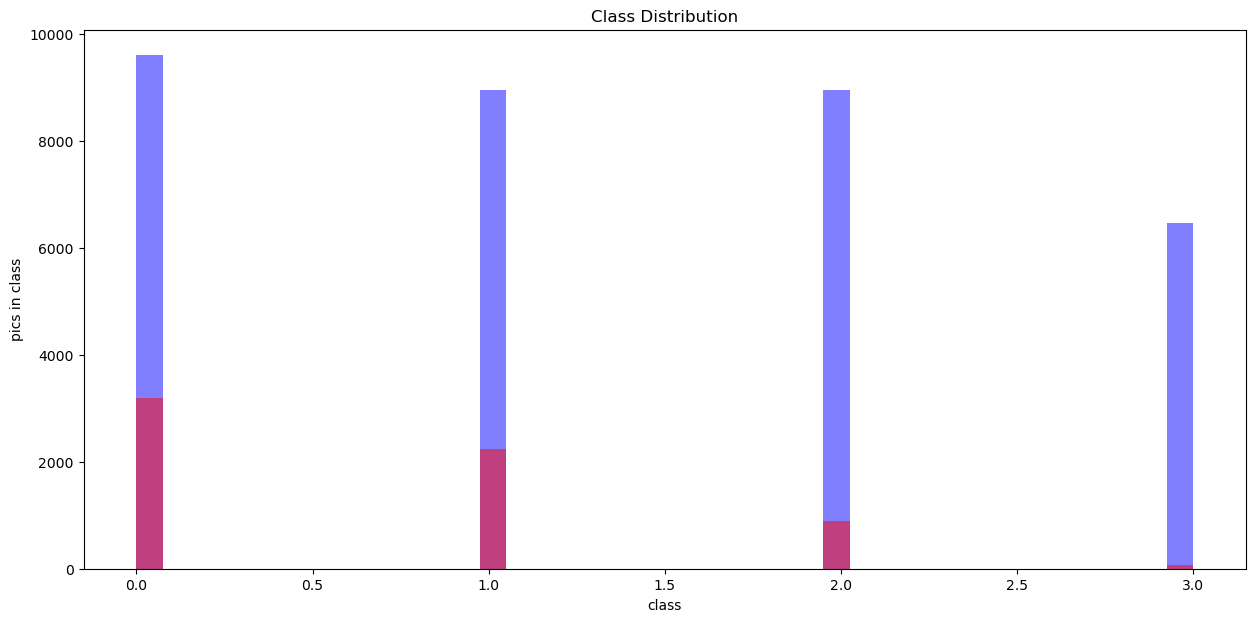

In [14]:
counts_augm, bins_augm = np.histogram(augm_df['class'].values, bins=40)
counts_orig, bins_orig = np.histogram(orig_df['class'].values, bins=40)
plt.figure(figsize=(15, 7))
plt.xlabel('class')
plt.ylabel('pics in class')
plt.title('Class Distribution')
plt.hist(bins_augm[:-1], bins_augm, weights=counts_augm, color='blue', alpha = 0.5)
plt.hist(bins_orig[:-1], bins_orig, weights=counts_orig, color='red', alpha = 0.5)
plt.show()

# Для третьего класса - ModerateDemented - сравнительно мало оригиналов (64) и много аугментаций сделано над ними (6464) - по 101 на каждую картинку, в остальных классах по 10 и менее на картинку. 
# Смотрим, как это примерно выглядит:

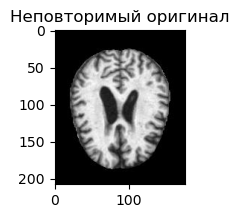

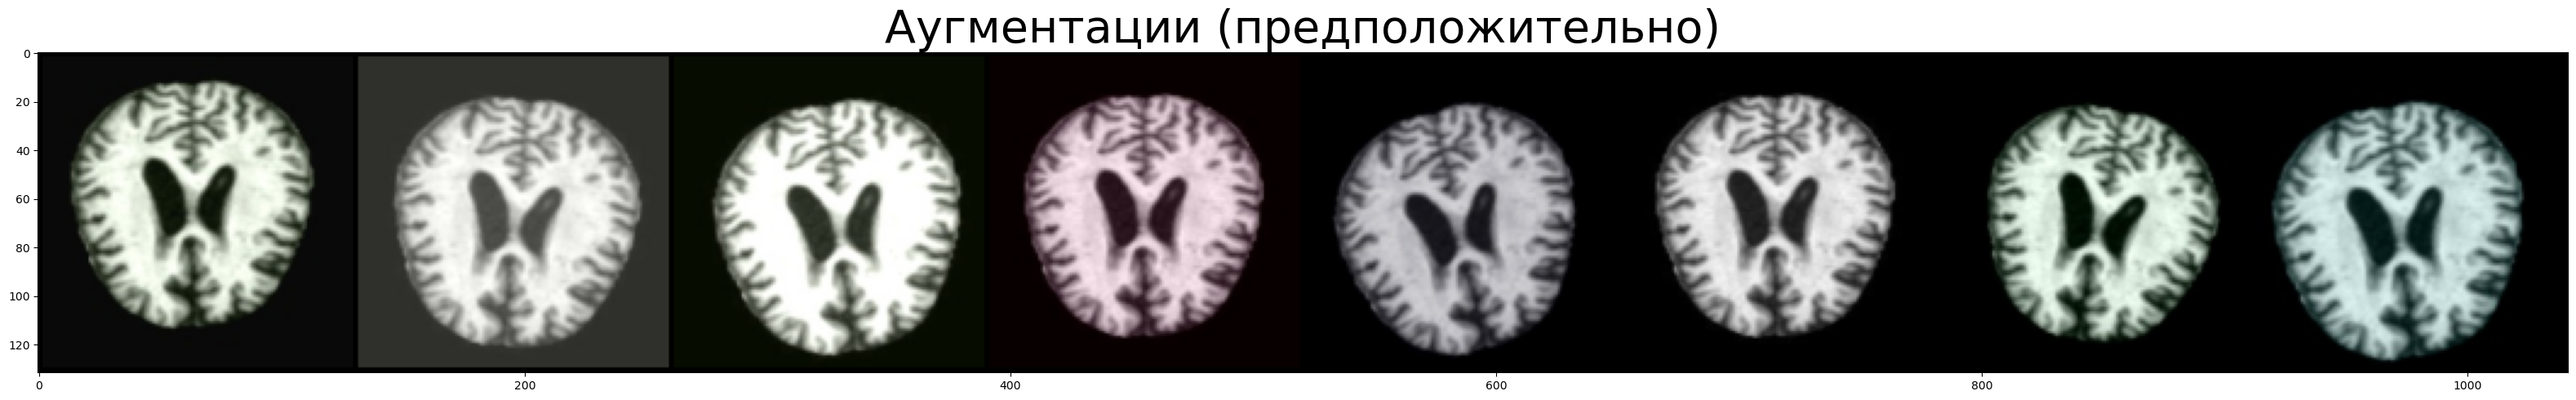

In [185]:
impath, target = orig_df[orig_df['class']==3].iloc[3]  
img = PIL.Image.open(impath).convert('RGB')
fig = plt.figure(figsize=(2, 2))
plt.title('Неповторимый оригинал')
plt.imshow(img)


imglist = []

for index in [107, 411, 451, 460, 483, 486, 541, 595]:
    impath, target = augm_df[augm_df['class']==3].iloc[index]        
    img = PIL.Image.open(impath).convert('RGB')    
        
    transform = transforms.Compose([transforms.Resize((128, 128), antialias=True),
                                        transforms.PILToTensor()])
    img = transform(img)
    imglist.append(img)
    
imglist = torchvision.utils.make_grid(imglist)
npimg = imglist.detach().numpy()
fig = plt.figure(figsize=(40, 80))
plt.title('Аугментации (предположительно)', fontsize = 40)
plt.imshow(npimg.transpose(1, 2, 0))  

# Предполагаю также, что в каждой папке оригинальных изображений - по сколько-то срезов одного и того же мозга, то есть соседние срезы достаточно похожи друг на друга, например:

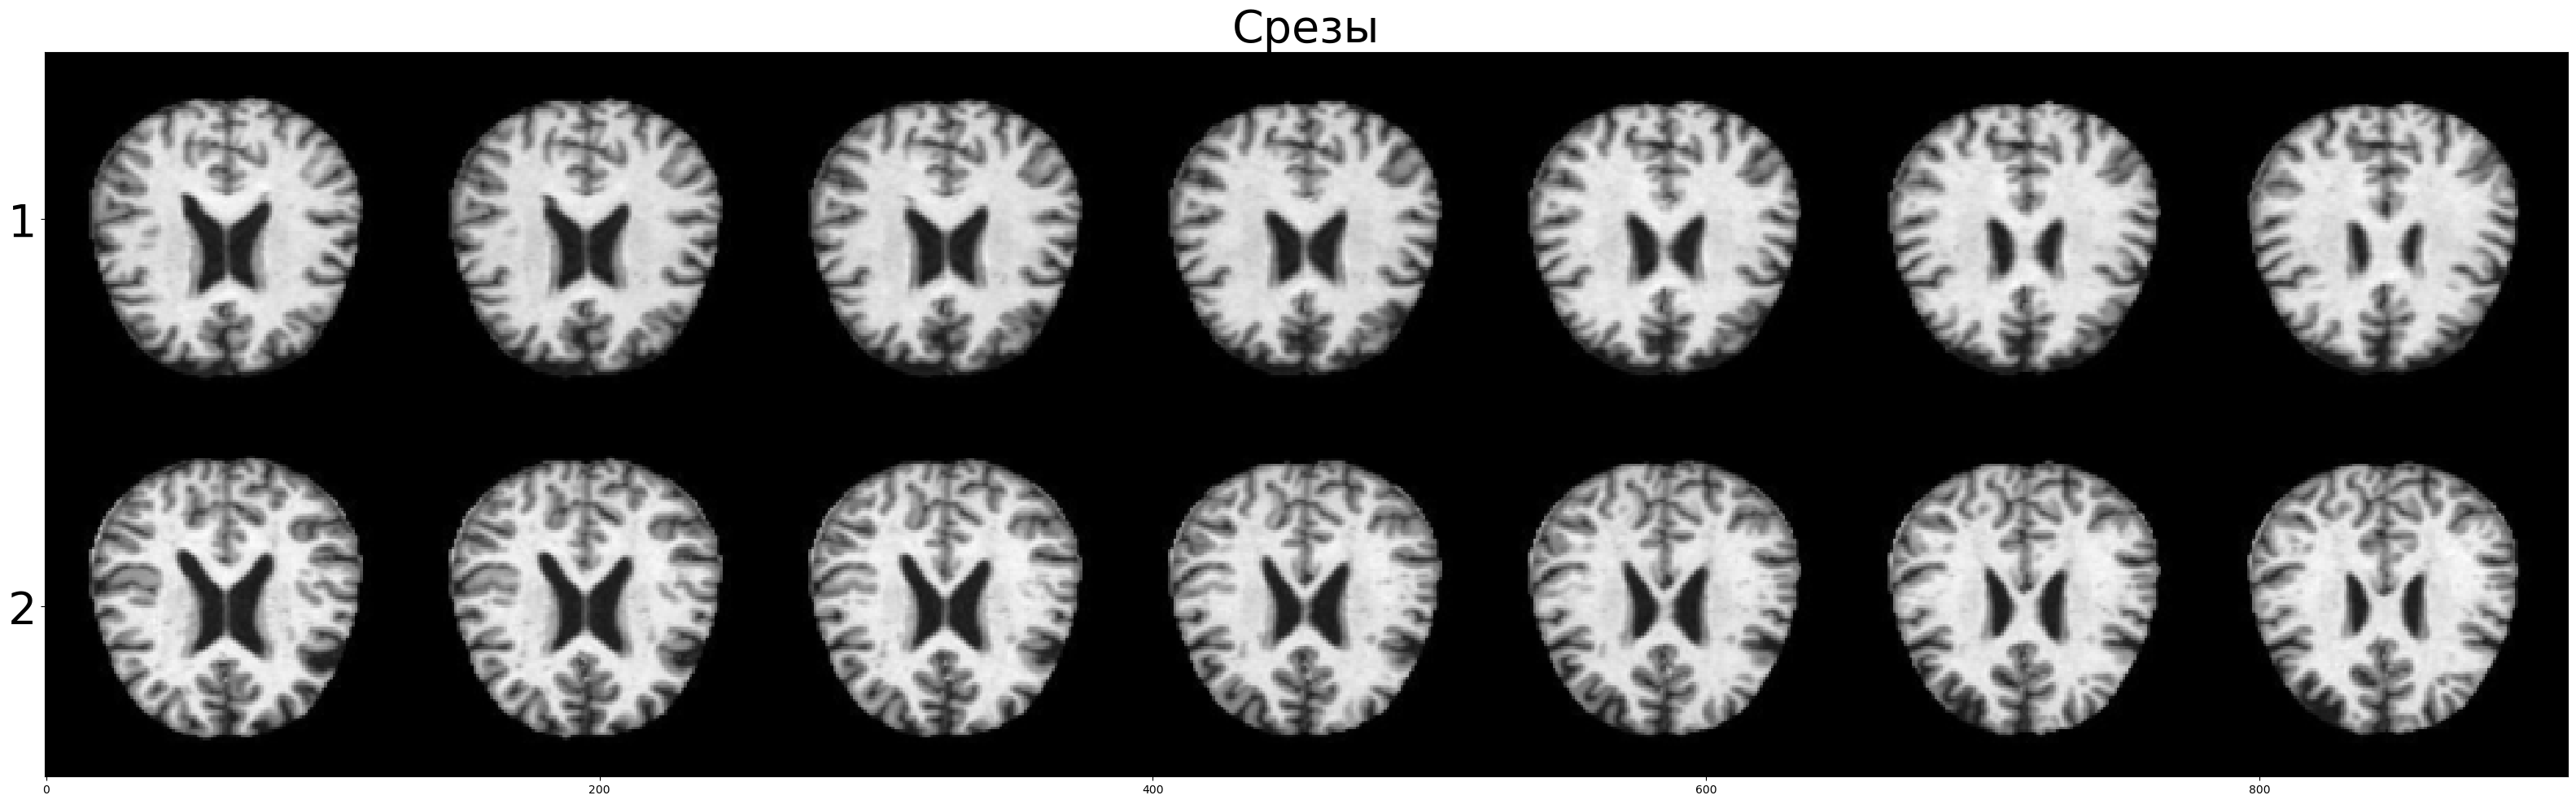

In [186]:
class0 = orig_df[orig_df['class']==0]
class062 = class0[class0.imname.apply(lambda x: '(62).jpg' in x)]
class061 = class0[class0.imname.apply(lambda x: '(63).jpg' in x)]

imglist = []

for index in class062.index:
    impath, target = orig_df.iloc[index]        
    img = PIL.Image.open(impath).convert('RGB')    
        
    transform = transforms.Compose([transforms.Resize((128, 128), antialias=True),
                                        transforms.PILToTensor()])
    img = transform(img)
    imglist.append(img)
    
for index in class061.index:
    impath, target = orig_df.iloc[index]        
    img = PIL.Image.open(impath).convert('RGB')    
        
    transform = transforms.Compose([transforms.Resize((128, 128), antialias=True),
                                        transforms.PILToTensor()])
    img = transform(img)
    imglist.append(img)
    
imglist = torchvision.utils.make_grid(imglist, nrow=7)
npimg = imglist.detach().numpy()
fig = plt.figure(figsize=(40, 80))
points = np.array([60, 200])
labels = [1, 2]
plt.yticks(points, labels, fontsize = 40)
plt.title('Срезы', fontsize = 40)
plt.imshow(npimg.transpose(1, 2, 0)) 

Но эти срезы в основном не пронумерованы, так что проследить, что какие-то изображения принадлежат одному и тому же мозгу - сложно. При этом если случайным образом делить датасет, то соседние срезы могут попасть один в обучающую выборку, другой в тестовую, и завысить результаты классификации (?), так как изображения достаточно похожие. В реальной жизни данные так приходить тоже не будут, мы будем хотеть классифицировать все изображения одного мозга сразу.

# Смотрим визуально как различаются 4 класса - ну не то чтобы что-то понятно

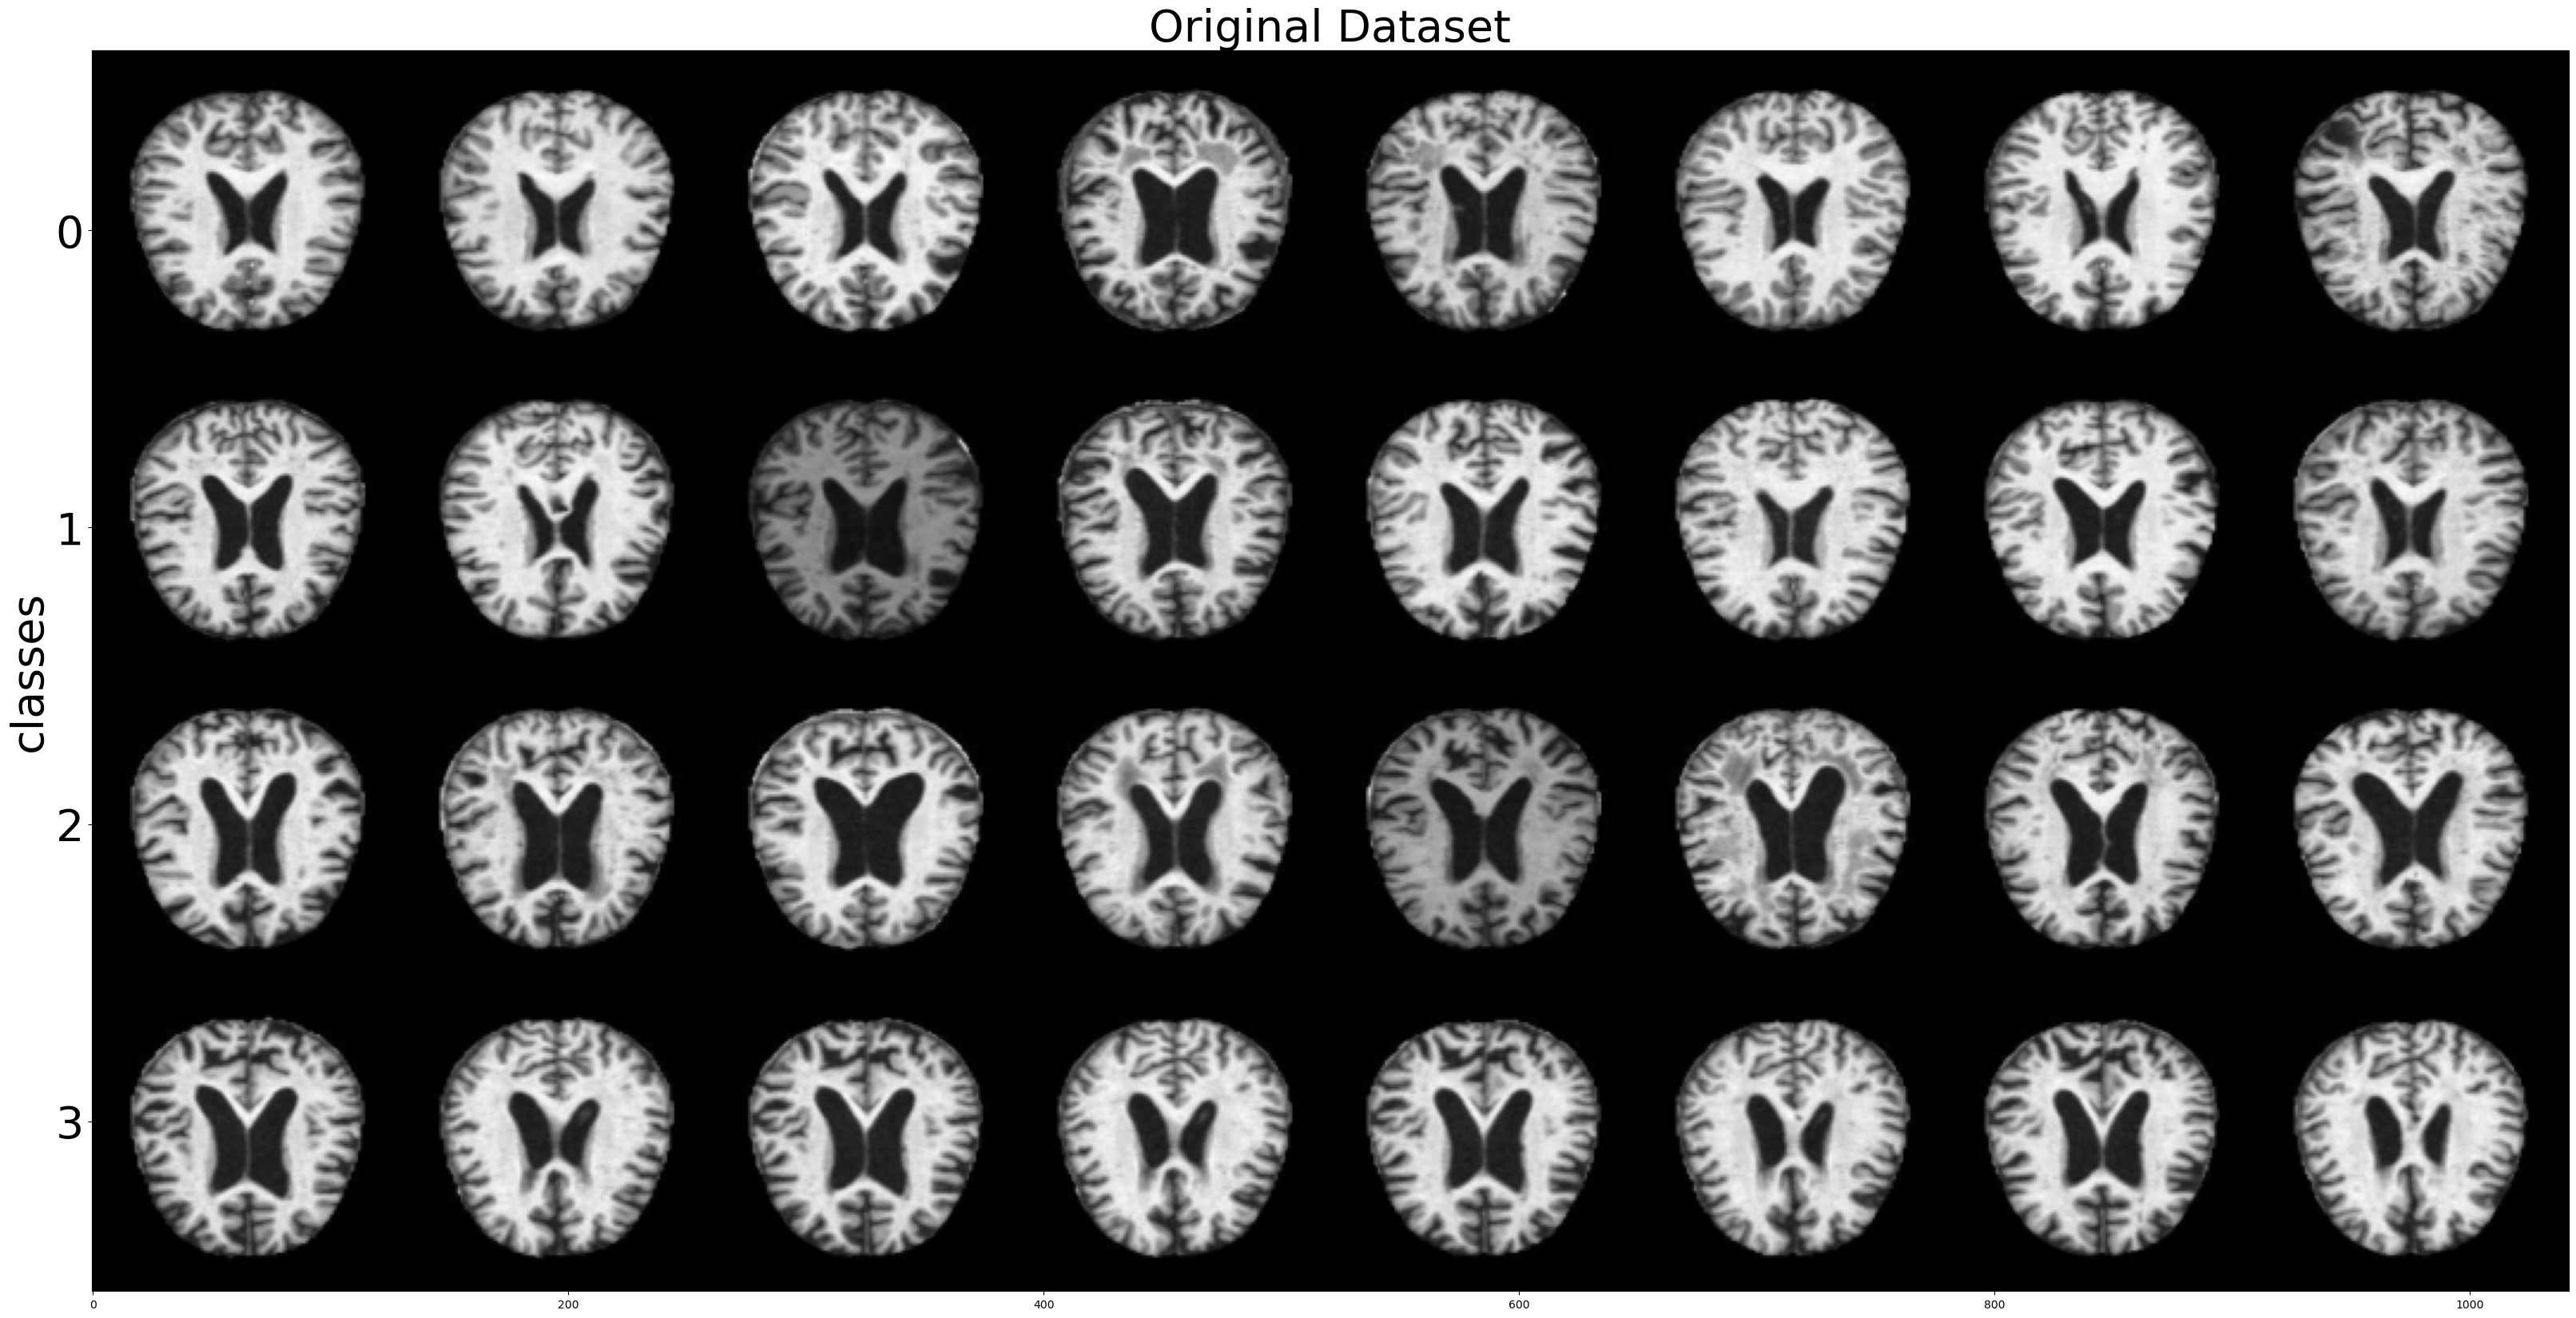

In [112]:
imglist = []

for class_ in range(4):
    for index in range(8):
        
        impath, target = orig_df[orig_df['class']==class_].iloc[index]        
        img = PIL.Image.open(impath).convert('RGB')    
        
        transform = transforms.Compose([transforms.Resize((128, 128), antialias=True),
                                        transforms.PILToTensor()])
        img = transform(img)
        imglist.append(img)
    
imglist = torchvision.utils.make_grid(imglist)
npimg = imglist.detach().numpy()
fig = plt.figure(figsize=(40, 80))
plt.title('Original Dataset', fontsize = 40)
plt.ylabel('classes', fontsize = 40)

points = np.array([75, 200, 325, 450])
labels = [0, 1, 2, 3]
plt.yticks(points, labels, fontsize = 40)
plt.imshow(npimg.transpose(1, 2, 0))


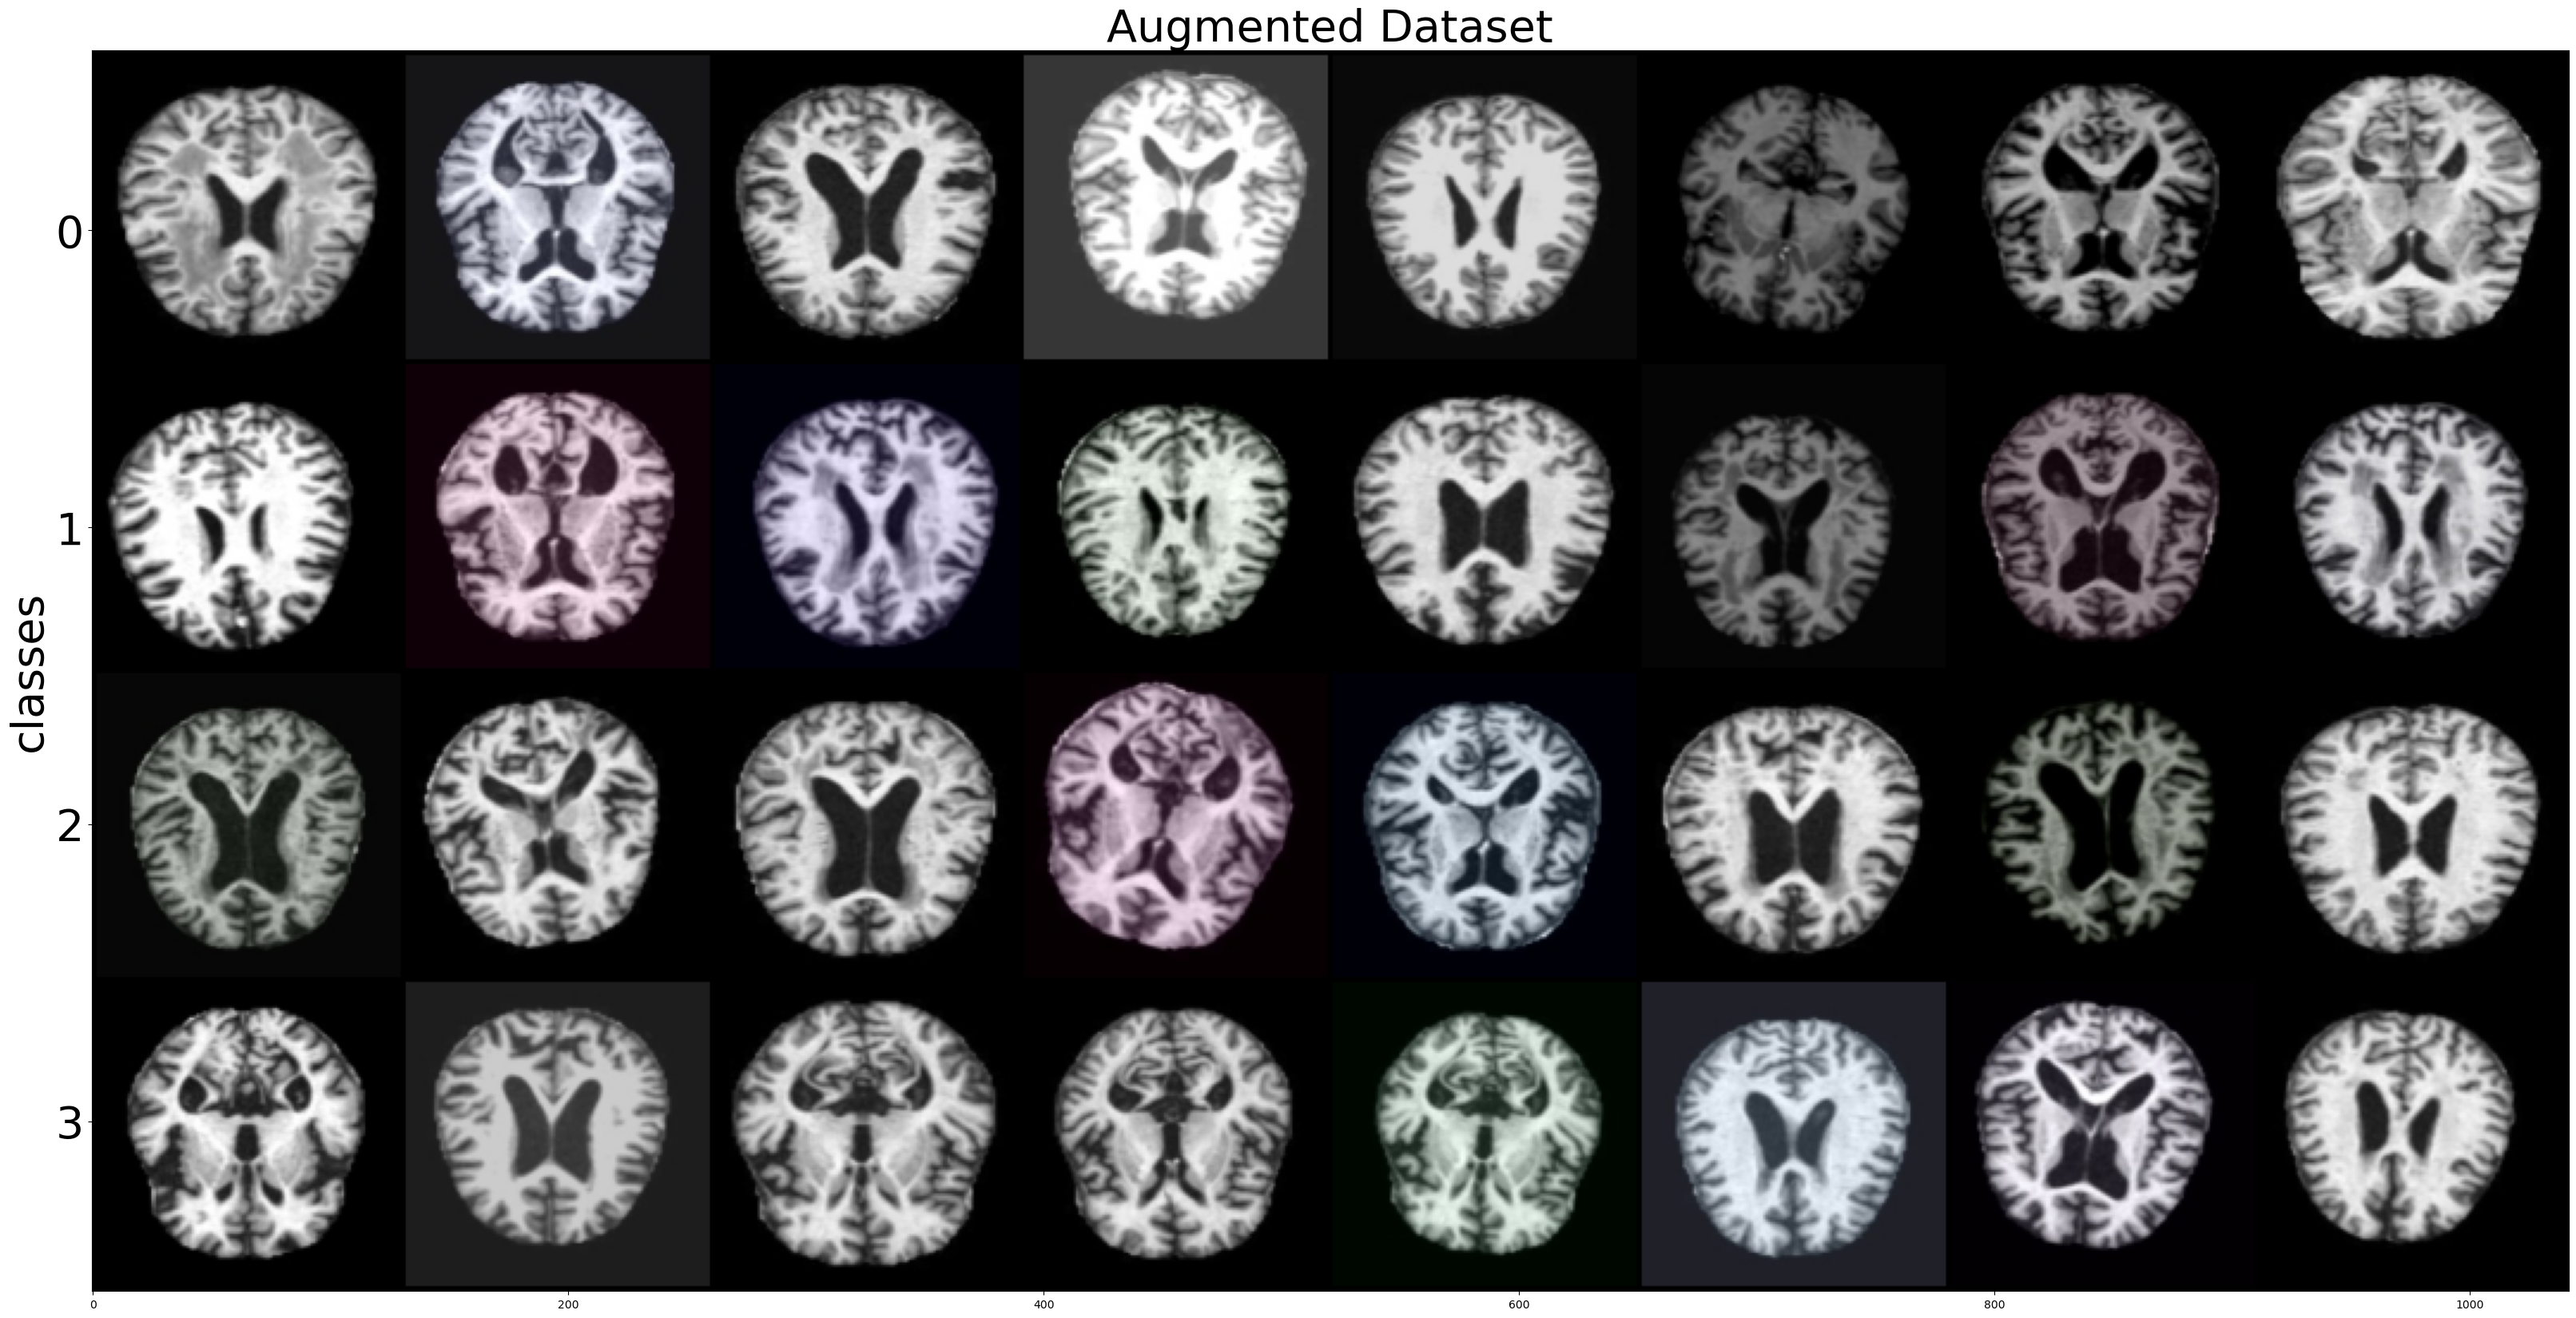

In [113]:
imglist = []

for class_ in range(4):
    for index in range(8):
        
        impath, target = augm_df[augm_df['class']==class_].iloc[index]        
        img = PIL.Image.open(impath).convert('RGB')    
        
        transform = transforms.Compose([transforms.Resize((128, 128), antialias=True),
                                        transforms.PILToTensor()])
        img = transform(img)
        imglist.append(img)
    
imglist = torchvision.utils.make_grid(imglist)
npimg = imglist.detach().numpy()
fig = plt.figure(figsize=(40, 80))
plt.title('Augmented Dataset', fontsize = 40)
plt.ylabel('classes', fontsize = 40)

points = np.array([75, 200, 325, 450])
labels = [0, 1, 2, 3]
plt.yticks(points, labels, fontsize = 40)
plt.imshow(npimg.transpose(1, 2, 0))

# Допустим, решаем задачу в формате: train данные это все из папки AugmentedAlzheimerDataset, а test это все из папки OriginalDataset

In [115]:
# формируем датасет из датафрейма

class SignDataset(data.Dataset):

    def __init__(self, dataframe, transform=None):
        self.imlist = dataframe 
        self.transform = transform
  
    def __getitem__(self, index):
        
        impath, target = self.imlist.loc[index]
        if not os.path.exists(impath): 
            print('No file ', impath)
            pass
            
        img = PIL.Image.open(impath).convert('RGB')
        img = self.transform(img)
 
        return img, target, impath


    def __len__(self):
        return len(self.imlist)    

In [116]:
def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(False) 

    
def fix_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)
    
    
def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [117]:
# конфиг с основными гиперпараметрами
@dataclass
class Config:
    seed: int = 24

    batch_size: int = 32
    img_size: int = 64

    n_epochs: int = 10
    lr: float = 1e-4

config = Config()
enable_determinism()
fix_seeds(config.seed)


generator = torch.Generator()
generator.manual_seed(config.seed)

In [118]:
transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True), # все картинки надо привести к одному размеру и не забыть про асиасинг
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

trainset = SignDataset(dataframe=augm_df, transform=transform)
testset = SignDataset(dataframe=orig_df, transform=transform)

trainloader = DataLoader(
    trainset, 
    batch_size=32, 
    #num_workers=12, 
    shuffle=True, 
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    generator=generator,
)

testloader = DataLoader(
    testset, 
    batch_size=32, 
   #num_workers=12, 
    pin_memory=True
)

In [119]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Device: ', device)

Device:  cuda


In [120]:
def run_epoch(epoch, net, loader, criterion, optimizer, device, is_train, wandb_log):

    if is_train:
        net.train()
    else:
        net.eval()
        
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    all_preds = []
    all_labels = []

    for i, data in enumerate(loader):
      
        images, labels, _= data
        images, labels = images.to(device), labels.to(device)
      
        outputs = net(images)
        loss = criterion(outputs, labels)
    
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
   
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds = np.concatenate((all_preds, predicted.cpu().numpy()))
        all_labels = np.concatenate((all_labels, labels.cpu().numpy()))
    
    acc = (all_preds == all_labels).sum()/len(all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    f1 = f1_score(all_labels, all_preds, average='weighted')
  
    print('Loss: {:.3f}, accuracy: {:.3f}, balanced: {:.3f}'.format(running_loss / (i + 1), acc * 100.0, bal_acc * 100.0))
    if wandb_log:
        if is_train:
            wandb.log({'train loss': running_loss / (i + 1)}, step=epoch)
            wandb.log({'train accuracy': acc}, step=epoch)
            wandb.log({'train weighted f1': f1}, step=epoch)
        else:
            wandb.log({'test loss': running_loss / (i + 1)}, step=epoch)
            wandb.log({'test accuracy': acc}, step=epoch)
            wandb.log({'test weighted f1': f1}, step=epoch)
        
    return all_preds, all_labels

# Использую RESNET34 с предобученными весами, потому что почему бы и нет

In [121]:
net = models.resnet34(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 4)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [01:53<00:00, 771kB/s]


In [122]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)

In [123]:
wandb.init(
    settings=wandb.Settings(init_timeout=90),
    project="Alzheimer MRI Dataset", 
    name="resnet_34", 
    config=config.__dict__
)


for epoch in range(config.n_epochs):
    # training
    print("Training epoch: ", epoch + 1, "/", config.n_epochs)
    _, _ = run_epoch(epoch, net, trainloader, criterion, optimizer, device, is_train=True, wandb_log=True)

    # validation
    print('Validation')
    with torch.no_grad():
        preds, labels = run_epoch(epoch, net, testloader, criterion, optimizer, device, is_train=False, wandb_log=True)
    print('----------------------')


wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bayou885 (bayou885-mephi). Use `wandb login --relogin` to force relogin


Training epoch:  1 / 10
Loss: 0.526, accuracy: 77.625, balanced: 78.932
Validation
Loss: 0.174, accuracy: 93.625, balanced: 96.136
----------------------
Training epoch:  2 / 10
Loss: 0.167, accuracy: 93.847, balanced: 94.259
Validation
Loss: 0.069, accuracy: 97.453, balanced: 98.258
----------------------
Training epoch:  3 / 10
Loss: 0.086, accuracy: 97.049, balanced: 97.246
Validation
Loss: 0.015, accuracy: 99.719, balanced: 99.859
----------------------
Training epoch:  4 / 10
Loss: 0.056, accuracy: 98.011, balanced: 98.137
Validation
Loss: 0.031, accuracy: 98.969, balanced: 99.397
----------------------
Training epoch:  5 / 10
Loss: 0.045, accuracy: 98.411, balanced: 98.509
Validation
Loss: 0.018, accuracy: 99.359, balanced: 99.562
----------------------
Training epoch:  6 / 10
Loss: 0.035, accuracy: 98.817, balanced: 98.891
Validation
Loss: 0.009, accuracy: 99.781, balanced: 99.850
----------------------
Training epoch:  7 / 10
Loss: 0.034, accuracy: 98.897, balanced: 98.969
Vali

In [124]:
confusion_matrix(labels, preds, normalize='true')   

array([[9.98437500e-01, 3.12500000e-04, 9.37500000e-04, 3.12500000e-04],
       [8.92857143e-04, 9.99107143e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.23214286e-03, 9.97767857e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Теперь пробую разделить на train и test аугментированные изображения случайным образом

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    augm_df.drop(columns='class'), augm_df['class'], test_size=0.15, random_state=42, stratify=augm_df['class'], shuffle=True)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [207]:
test_df['class'].value_counts()

class
0    1440
2    1344
1    1344
3     970
Name: count, dtype: int64

In [208]:
train_df['class'].value_counts()

class
0    8160
2    7616
1    7616
3    5494
Name: count, dtype: int64

In [209]:
transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True), # все картинки надо привести к одному размеру и не забыть про асиасинг
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

trainset = SignDataset(dataframe=train_df, transform=transform)
testset = SignDataset(dataframe=test_df, transform=transform)

trainloader = DataLoader(
    trainset, 
    batch_size=32, 
    #num_workers=12, 
    shuffle=True, 
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    generator=generator,
)

testloader = DataLoader(
    testset, 
    batch_size=32, 
   #num_workers=12, 
    pin_memory=True
)

In [210]:
net = models.resnet34(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 4)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)

In [211]:
wandb.init(
    settings=wandb.Settings(init_timeout=90),
    project="Alzheimer MRI Dataset", 
    name="resnet_34_augmented_dataset", 
    config=config.__dict__
)


for epoch in range(config.n_epochs):
    # training
    print("Training epoch: ", epoch + 1, "/", config.n_epochs)
    _, _ = run_epoch(epoch, net, trainloader, criterion, optimizer, device, is_train=True, wandb_log=True)

    # validation
    print('Validation')
    with torch.no_grad():
        preds, labels = run_epoch(epoch, net, testloader, criterion, optimizer, device, is_train=False, wandb_log=True)
    print('----------------------')


wandb.finish()

Training epoch:  1 / 10
Loss: 0.578, accuracy: 75.641, balanced: 76.979
Validation
Loss: 0.294, accuracy: 88.446, balanced: 89.407
----------------------
Training epoch:  2 / 10
Loss: 0.199, accuracy: 92.631, balanced: 93.163
Validation
Loss: 0.175, accuracy: 93.801, balanced: 94.367
----------------------
Training epoch:  3 / 10
Loss: 0.101, accuracy: 96.335, balanced: 96.587
Validation
Loss: 0.080, accuracy: 96.901, balanced: 97.120
----------------------
Training epoch:  4 / 10
Loss: 0.069, accuracy: 97.616, balanced: 97.771
Validation
Loss: 0.108, accuracy: 96.352, balanced: 96.694
----------------------
Training epoch:  5 / 10
Loss: 0.053, accuracy: 98.185, balanced: 98.303
Validation
Loss: 0.088, accuracy: 96.901, balanced: 97.098
----------------------
Training epoch:  6 / 10
Loss: 0.038, accuracy: 98.732, balanced: 98.827
Validation
Loss: 0.067, accuracy: 97.685, balanced: 97.893
----------------------
Training epoch:  7 / 10
Loss: 0.035, accuracy: 98.857, balanced: 98.934
Vali

In [212]:
confusion_matrix(labels, preds, normalize='true')

array([[0.97847222, 0.02013889, 0.00138889, 0.        ],
       [0.0141369 , 0.984375  , 0.0014881 , 0.        ],
       [0.00520833, 0.00892857, 0.9858631 , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

Класс ModerateDemented отделяется идеально, скорее всего потому что очень много аугментаций одного и того же. В качестве валидации тут можно прогнать оригинальный датасет.

In [215]:
validset = SignDataset(dataframe=orig_df, transform=transform)

validloader = DataLoader(
    validset, 
    batch_size=32
)

with torch.no_grad():
    preds, labels = run_epoch(epoch, net, validloader, criterion, optimizer, device, is_train=False, wandb_log=False)
    
confusion_matrix(labels, preds, normalize='true')

Loss: 0.007, accuracy: 99.797, balanced: 99.892


array([[9.96562500e-01, 3.43750000e-03, 0.00000000e+00, 0.00000000e+00],
       [8.92857143e-04, 9.99107143e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Теперь делаю то же самое, но формирую train и test по-другому - сначала отбираю из original сколько-то картинок на test случайным образом, затем остальное идёт в train

In [216]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.drop(columns='class'), orig_df['class'], test_size=0.20, random_state=42, stratify=orig_df['class'], shuffle=True)

In [217]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [218]:
test_df['class'].value_counts()

class
0    640
1    448
2    179
3     13
Name: count, dtype: int64

In [219]:
train_df['class'].value_counts()

class
0    2560
1    1792
2     717
3      51
Name: count, dtype: int64

In [220]:
transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True), # все картинки надо привести к одному размеру и не забыть про асиасинг
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

trainset = SignDataset(dataframe=train_df, transform=transform)
testset = SignDataset(dataframe=test_df, transform=transform)

trainloader = DataLoader(
    trainset, 
    batch_size=32, 
    #num_workers=12, 
    shuffle=True, 
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    generator=generator,
)

testloader = DataLoader(
    testset, 
    batch_size=32, 
   #num_workers=12, 
    pin_memory=True
)

In [221]:
net = models.resnet34(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 4)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)

In [222]:
wandb.init(
    settings=wandb.Settings(init_timeout=90),
    project="Alzheimer MRI Dataset", 
    name="resnet_34_no_augmentations", 
    config=config.__dict__
)


for epoch in range(config.n_epochs):
    # training
    print("Training epoch: ", epoch + 1, "/", config.n_epochs)
    _, _ = run_epoch(epoch, net, trainloader, criterion, optimizer, device, is_train=True, wandb_log=True)

    # validation
    print('Validation')
    with torch.no_grad():
        preds, labels = run_epoch(epoch, net, testloader, criterion, optimizer, device, is_train=False, wandb_log=True)
    print('----------------------')


wandb.finish()

Training epoch:  1 / 10
Loss: 0.849, accuracy: 62.988, balanced: 44.192
Validation
Loss: 0.583, accuracy: 76.094, balanced: 56.248
----------------------
Training epoch:  2 / 10
Loss: 0.410, accuracy: 84.336, balanced: 72.006
Validation
Loss: 0.356, accuracy: 86.016, balanced: 86.022
----------------------
Training epoch:  3 / 10
Loss: 0.210, accuracy: 92.070, balanced: 91.899
Validation
Loss: 0.300, accuracy: 89.297, balanced: 90.134
----------------------
Training epoch:  4 / 10
Loss: 0.144, accuracy: 94.648, balanced: 93.975
Validation
Loss: 0.231, accuracy: 92.812, balanced: 93.098
----------------------
Training epoch:  5 / 10
Loss: 0.087, accuracy: 96.914, balanced: 95.953
Validation
Loss: 0.156, accuracy: 95.234, balanced: 88.674
----------------------
Training epoch:  6 / 10
Loss: 0.082, accuracy: 97.070, balanced: 97.109
Validation
Loss: 0.210, accuracy: 93.828, balanced: 89.547
----------------------
Training epoch:  7 / 10
Loss: 0.074, accuracy: 97.285, balanced: 95.700
Vali

In [223]:
confusion_matrix(labels, preds, normalize='true')

array([[0.9921875 , 0.0078125 , 0.        , 0.        ],
       [0.03794643, 0.93526786, 0.02678571, 0.        ],
       [0.03351955, 0.03910615, 0.9273743 , 0.        ],
       [0.        , 0.07692308, 0.        , 0.92307692]])

Здесь уже класс 3 хуже всех из-за недостаточности данных, но в целом всё еще неплохо

# Теперь пробую в качестве тестовых отобрать все срезы для нескольких (предположительно) экземпляров мозга из тех что пронумерованы в датасете

In [229]:
class0 = orig_df[orig_df['class']==0]
index0 = []
for n in range(62, 72):
    class0n = class0[class0.imname.apply(lambda x: '(' + str(n) +').jpg' in x)]
    index0 += class0n.index.to_list()


class1 = orig_df[orig_df['class']==1]
index1 = []
for n in range(44, 54):
    class1n = class1[class1.imname.apply(lambda x: '(' + str(n) +').jpg' in x)]
    index1 += class1n.index.to_list()


class2 = orig_df[orig_df['class']==2]
index2 = []
for n in range(19, 29):
    class2n = class2[class2.imname.apply(lambda x: '(' + str(n) +').jpg' in x)]
    index2 += class2n.index.to_list()

class3 = orig_df[orig_df['class']==3]
class32 = class3[class3.imname.apply(lambda x: '(2).jpg' in x)]
index3 = class32.index.to_list()

test_index = index0 + index1 + index2 + index3

In [230]:
test_df = orig_df[orig_df.index.isin(test_index)].reset_index(drop=True)
train_df = orig_df[~orig_df.index.isin(test_index)].reset_index(drop=True)

test_df['class'].value_counts(), train_df['class'].value_counts()

(class
 2    70
 0    70
 1    70
 3     6
 Name: count, dtype: int64,
 class
 0    3130
 1    2170
 2     826
 3      58
 Name: count, dtype: int64)

In [231]:
transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size), antialias=True), # все картинки надо привести к одному размеру и не забыть про асиасинг
    transforms.PILToTensor(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
])

trainset = SignDataset(dataframe=train_df, transform=transform)
testset = SignDataset(dataframe=test_df, transform=transform)

trainloader = DataLoader(
    trainset, 
    batch_size=32, 
    #num_workers=12, 
    shuffle=True, 
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker,
    generator=generator,
)

testloader = DataLoader(
    testset, 
    batch_size=32, 
   #num_workers=12, 
    pin_memory=True
)

In [232]:
net = models.resnet34(weights='DEFAULT')
net.fc = nn.Linear(net.fc.in_features, 4)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)

In [233]:
wandb.init(
    settings=wandb.Settings(init_timeout=90),
    project="Alzheimer MRI Dataset", 
    name="resnet_34_no_augm_custom_test", 
    config=config.__dict__
)


for epoch in range(config.n_epochs):
    # training
    print("Training epoch: ", epoch + 1, "/", config.n_epochs)
    _, _ = run_epoch(epoch, net, trainloader, criterion, optimizer, device, is_train=True, wandb_log=True)

    # validation
    print('Validation')
    with torch.no_grad():
        preds, labels = run_epoch(epoch, net, testloader, criterion, optimizer, device, is_train=False, wandb_log=True)
    print('----------------------')


wandb.finish()

Training epoch:  1 / 10
Loss: 0.813, accuracy: 63.682, balanced: 44.493
Validation
Loss: 1.685, accuracy: 49.537, balanced: 38.214
----------------------
Training epoch:  2 / 10
Loss: 0.348, accuracy: 86.707, balanced: 79.792
Validation
Loss: 0.920, accuracy: 64.815, balanced: 50.000
----------------------
Training epoch:  3 / 10
Loss: 0.180, accuracy: 93.426, balanced: 91.792
Validation
Loss: 1.820, accuracy: 57.407, balanced: 44.286
----------------------
Training epoch:  4 / 10
Loss: 0.102, accuracy: 96.324, balanced: 95.406
Validation
Loss: 1.612, accuracy: 62.037, balanced: 51.667
----------------------
Training epoch:  5 / 10
Loss: 0.082, accuracy: 97.183, balanced: 96.346
Validation
Loss: 2.475, accuracy: 55.556, balanced: 42.857
----------------------
Training epoch:  6 / 10
Loss: 0.077, accuracy: 97.506, balanced: 96.432
Validation
Loss: 1.877, accuracy: 56.481, balanced: 43.571
----------------------
Training epoch:  7 / 10
Loss: 0.038, accuracy: 98.705, balanced: 98.062
Vali

In [234]:
confusion_matrix(labels, preds, normalize='true')

array([[0.87142857, 0.12857143, 0.        , 0.        ],
       [0.28571429, 0.71428571, 0.        , 0.        ],
       [0.41428571, 0.22857143, 0.35714286, 0.        ],
       [0.83333333, 0.        , 0.        , 0.16666667]])

Здесь результаты уже не такие впечатляющие, такие графики характерны для переобучения. Есть подозрение что с датасетом в целом что-то не так и мы получаем хорошие метрики только за счет обучения на конкретных похожих картинках, которые являются соседними срезами одного и того же мозга, но попадают при этом одни в тест, а другие в трейн. А какие-то реальные признаки альцгеймера мы тут не улавливаем. Если бы в датасете все изображения были бы сгруппированы, как относящиеся к конкретному человеку, то можно было бы исследовать точнее. Конец.

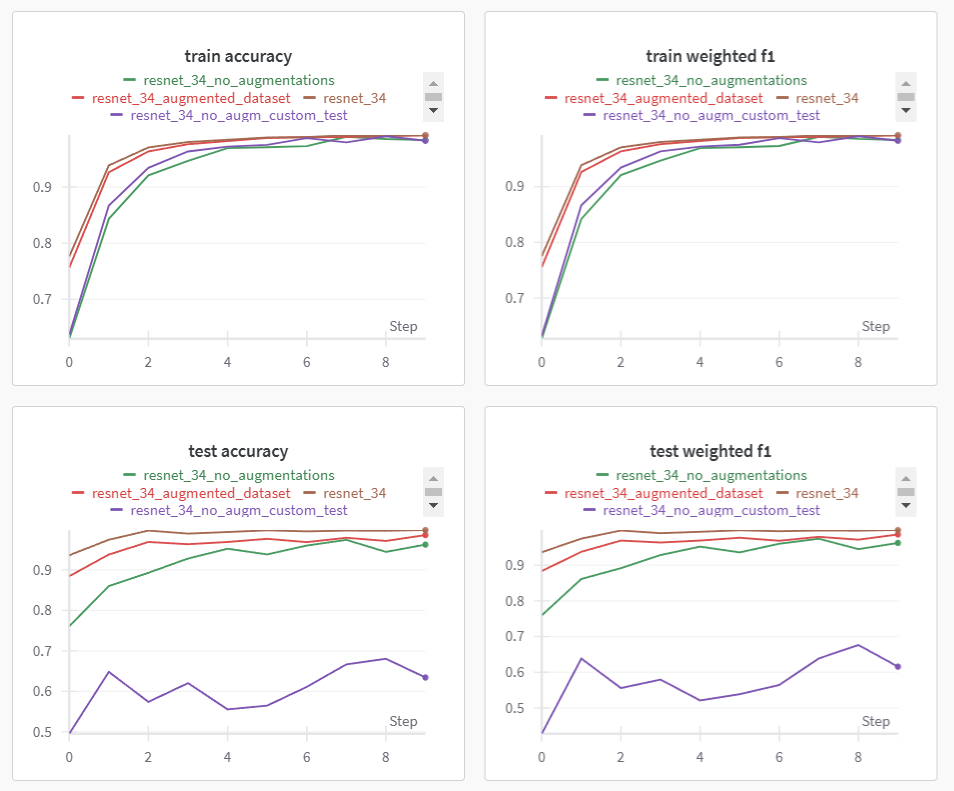